In [1]:
# --------------------------------
# Name: random_errors_filter.ipynb
# Author: Brian R. Greene
# University of Oklahoma
# Created: 28 April 2021
# Purpose: Read volumetric output from LES to calculate autocorrelations,
# integral length scales, and random error profiles by using filtering
# method from Salesky et al. 2012
# --------------------------------

In [2]:
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import signal

In [3]:
# Configure plots
rc('font',weight='normal',size=20,family='serif',serif='Computer Modern Roman')
rc('text',usetex='True')

In [4]:
def read_f90_bin(path,nx,ny,nz,precision):  
    print(f"Reading file: {path}")
    f=open(path,'rb')
    if (precision==4):
        dat=np.fromfile(f,dtype='float32',count=nx*ny*nz)
    elif (precision==8):
        dat=np.fromfile(f,dtype='float64',count=nx*ny*nz)
    else:
        raise ValueError('Precision must be 4 or 8')
    dat=np.reshape(dat,(nx,ny,nz),order='F')
    f.close()
    return dat

# Start by looking at one file - A_128_interp

In [69]:
# read last u file
fdir = "/home/bgreene/simulations/A_128_interp/output/"
f1 = f"{fdir}u_1260000.out"
# dimensions
nx, ny, nz = 128, 128, 128
Lx, Ly, Lz = 800., 800., 400.
dx, dy, dz = Lx/(nx-1), Ly/(ny-1), Lz/(nz-1)
# load file
u_in = read_f90_bin(f1,nx,ny,nz,8)
# grab 1d slice for testing
kz = 0
ux0 = u_in[:,64,kz]

Reading file: /home/bgreene/simulations/A_128_interp/output/u_1260000.out


In [70]:
# load average statistics to get <U>
fstat = f"{fdir}average_statistics.csv"
dstat = np.loadtxt(fstat, delimiter=",", skiprows=1)
Ubar = dstat[:,1]

# specify some filter parameters
# f_min = 10.*(dz/2.)/Ubar[0] # f_min ~= 10*Tau_f ~= 10*z/Ubar
# f_min = 1.
f_min = dx
# f_max = (Lx/Ubar[0])/4. # f_max ~= T/10
# f_max = 3600.
f_max = Lx
# f_min = 2. * dx
# f_max = (nx//4) * dx
nf = 100
# set up logspace array of filter widths as function of delta_t
delta_x = np.logspace(np.log10(f_min), np.log10(f_max), num=nf, base=10.0)
# set up array of std of filtered flux as fn of delta_t
sigma_f = np.zeros(nf, dtype=float)

In [71]:
# start looping over filter sizes
for k in range(nf):
    # filter f at scale delta_t
    # wavenumber increment
    dk = 2.*np.pi / Lx
    # spatial filter via Taylor
#     delta_x = delta_t[k] * ux0.mean()
    # set up array of filter transfer function
    filt = np.zeros(nx//2, dtype=float)
    # assemble transfer function of box filter
    for i in range(1, nx//2):
        filt[i] = np.sin((i)*dk*delta_x[k]/2.)/((i)*dk*delta_x[k]/2.)
    
    # forward FFT
    f_fft = fft(ux0)
    
    # filter
    for i in range(1, nx//2):
        f_fft[i] *= filt[i]
        f_fft[nx-i-1] *= filt[i]
#         if k==0:
#             print(i, nx-i-1)
    
    # inverse FFT
    f_filtered = ifft(f_fft)
    
    # calc standard deviation 
    sigma_f[k] = np.std(f_filtered)

In [72]:
# fit power law to stdev of local filtered f
A = delta_x ** (-0.5)

# reshape sigma_f and A into shape(1, nf) to enable least sqaures solution
C_wc = np.dot(sigma_f.reshape(1,-1), np.linalg.pinv(A.reshape(1,-1)))[0][0]
# C_wc = sigma_f/A

# evaluate power law fit for delta_t = T to obtain error estimate
stdev_f = C_wc*((3.)**-0.5)

# calculate variance of unfiltered data
var_flux = np.var(ux0)
# grab variance of unfiltered data from stats file
# var_flux = dstat[0, 13]

# estimate integral timescale of ux0 from power law coefficient
tau_f = (C_wc**2.) / (2.*var_flux)

Text(800.0, 0.02, '$L_x$')

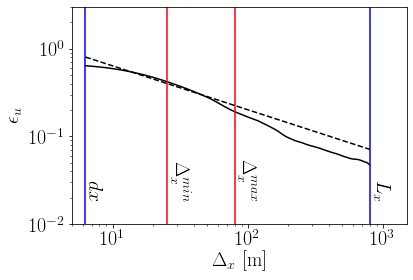

In [73]:
plt.plot(delta_x, sigma_f/Ubar[kz], "-k")
plt.xscale("log")
plt.xlim([5, 1500])
plt.yscale("log")
plt.ylim([0.01, 3])
# plt.axvline(3600., c="r")
# plt.axvline(3., c="k")
# plt.axvline(Lx/ux0.mean(), c="b")
# plt.axvline(dx/ux0.mean(), c="b")
plt.axvline(dx, c="b")
plt.axvline(Lx, c="b")
# plt.xlim([10, 300])
plt.xlabel("$\Delta_x$ [m]")
plt.ylabel("$\epsilon_u$")

delta_x_min = 4.*dx
delta_x_max = Lx/10.

plt.axvline(delta_x_min, c="r")
plt.axvline(delta_x_max, c="r")

ixuse = np.where((delta_x >= delta_x_min) & (delta_x <= delta_x_max))[0]

C_fit = np.dot((sigma_f[ixuse]/Ubar[kz]).reshape(1,-1), np.linalg.pinv(A[ixuse].reshape(1,-1)))[0][0]

plt.plot(delta_x, C_fit*(delta_x**-0.5), "--k")

plt.annotate('$dx$', xy=(dx, 0.02), xytext=(dx, 0.02), rotation=270)
plt.annotate('$\Delta_x^{min}$', xy=(delta_x_min, 0.02), xytext=(delta_x_min, 0.02), rotation=270)
plt.annotate('$\Delta_x^{max}$', xy=(delta_x_max, 0.02), xytext=(delta_x_max, 0.02), rotation=270)
plt.annotate('$L_x$', xy=(Lx, 0.02), xytext=(Lx, 0.02), rotation=270)

In [27]:
C_fit * Lx**-0.5

0.08191420458406332

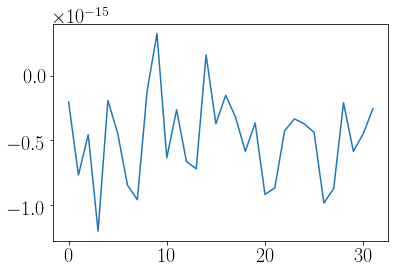

In [14]:
box = np.real(np.fft.fft(filt))
plt.plot(box[:nx//4])

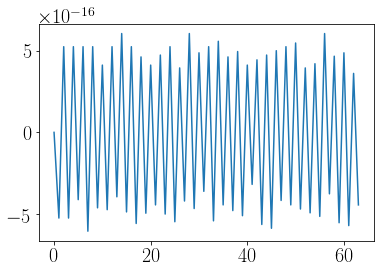

In [15]:
plt.plot(filt)

In [ ]:
C_fit * ((3./Ubar[0])**-0.5)

In [ ]:
stdev_f/Ubar[0]

In [ ]:
var_flux, np.var(ux0)

In [ ]:
sigma_f/A

In [ ]:
ux0.mean()

In [ ]:
sigma_f2 = np.zeros((1, len(sigma_f)), dtype=float)
sigma_f2[0,:] = sigma_f
A2 = np.zeros((1, len(A)), dtype=float)
A2[0,:] = A
np.linalg.lstsq(A2.T, sigma_f2.T, rcond=None)[0]

In [ ]:
np.dot(sigma_f2, np.linalg.pinv(A2))[0][0]

In [ ]:
x = np.arange(10, dtype=float)
x.reshape(1,10)

In [ ]:
a = np.array([1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,8,9])
a = a.reshape(1,-1)
b = np.ones((25,18))
np.dot(a, np.linalg.pinv(b))

In [ ]:
np.dot(sigma_f.reshape(1,-1), np.linalg.pinv(A.reshape(1,-1)))[0][0]

In [ ]:
import numba

In [10]:
(dx*dy*dz)**(1./3)

4.999688352655746

In [20]:
4.*dx, Lx

(25.19685039370079, 800.0)

(0, 30)

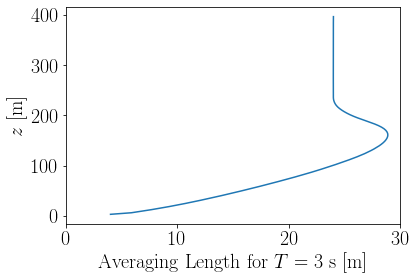

In [60]:
plt.plot(Ubar*3., np.linspace(dz, Lz-dz, nz))
plt.xlabel("Averaging Length for $T=3$ s [m]")
plt.ylabel("$z$ [m]")
plt.xlim([0, 30])

Text(0.5, 0, 'Relative error [$\\%$]')

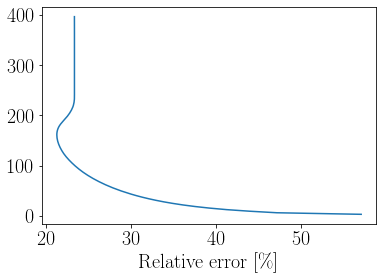

In [62]:
Tmean = 3. # seconds
Lmean = Ubar * Tmean # meters
rel_err = C_fit * (Lmean**-0.5)

plt.plot(rel_err*100., np.linspace(dz, Lz-dz, nz))
plt.xlabel("Relative error [$\%$]")
# plt.xlim([30, 130])

In [68]:
dz*4

12.598425196850394